# ***4 Phase Flowing Bottom Hole Pressure Calculation***

# Importing Libraries

In [7]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate as integrate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from scipy.optimize import minimize
from ipywidgets import interact, interactive, fixed, interact_manual
%config InlineBackend.figure_format = "svg"
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Assigning Variables: Reservoir, Fluid Properties

In [2]:
# Fluid PVT:
sp_gravity_oil = 0.81 
sp_gravity_gas = 0.81
sp_gravity_water = 1.021
sp_gravity_sand = 0



# Reservoir Properties:

p_reservoir = 7584
p_bubble = 4450
Rs_i = 3620.717
Bo_i = 2.577
Bg_i = 0.0028
Bw_i = 0.955
mu_o_i = 0.207
mu_g_i = 0.046
mu_w_i = 0.636

Reser_Temp_F = 163 # Reservoir Temp
Reser_Temp_R = Reser_Temp_F + 459.67
API = 45.2

# Wellbore Parameters:

L = 10500 # Casing Depth in ft
wellbore_OD_in = 5.5
wellbore_OD_ft = wellbore_OD_in/12
wellbore_ID_in = 4.778
wellbore_radius_in = wellbore_ID_in/2
wellbore_ID_ft = wellbore_ID_in/12
wellbore_radius_ft = wellbore_ID_ft/2
wellhead_Temp_F = 130
wellhead_Temp_R = wellhead_Temp_F + 459.67
surface_temp_F = 60
ar_wellbore = math.pi * wellbore_radius_ft ** 2 #cross-section area of the wellbore
theta = 0 # inclination angle, Degree
dh = wellbore_OD_ft-wellbore_ID_ft # Hydraulic Diameter in ft
epi = 0.000015 # pipe wall roughness, ft

#Misc:
gravity = 32.17  # ft/s^2

#### Let us define the functions used in Four Phase BHFP calculations

In [3]:
# Qs = Flow rate of sand()
# Qw = Flow rate of water(BOPD)
# Qo = Flow rate of oil(BOPD)
# Qg = Flow rate of gas(SCFD)

def a(Qs, Qw, Qo, Qg):
    nu = ((15.33 * sp_gravity_sand * Qs) + 
          (86.07 * sp_gravity_water * Qw) + (86.07 * sp_gravity_oil * Qo) + (0.01879 * sp_gravity_gas * Qg))
    de = Reser_Temp_R * Qg
    return nu / de


def b(Qs, Qw, Qo, Qg):
    nu = 0.2456 * Qs + 1.379 * (Qo + Qw)
    de = Reser_Temp_R * Qg
    return nu / de


def c(Qg):
    nu = (4.712*10**-5) * Reser_Temp_R * Qg
    de = ar_wellbore
    return nu / de


def d(Qs, Qw, Qo):
    nu = Qs + 5.615 * (Qw + Qo)
    de = 86400 * ar_wellbore
    return nu / de


def f():
    nu = 1
    de = 1.74 - (2 * (math.log((2 * epi / dh), 10)))
    return (nu / de) ** 2


def e():
    nu = f()
    de = 2 * gravity * dh * math.cos(theta)
    return nu / de


def m(Qs, Qw, Qo, Qg):
    nu = c(Qg) * d(Qs, Qw, Qo) * e()
    de = 1 + (d(Qs, Qw, Qo) ** 2) * e()
    return nu / de


def n(Qs, Qw, Qo, Qg):
    nu = (c(Qg) ** 2) * e()
    de = (1 + (d(Qs, Qw, Qo) ** 2) * e()) ** 2
    return nu / de


def Four_Phase_BHFP():
    
    df = pd.read_excel(r"C:\Users\apoor\Desktop\4 Phase BHP\RTA_Worksheet.xlsx", "Calculation", header=0)
    Qo = df['Oil Rate, q']
    Qg = df['Gas Rate, SCFD']
    Qw = df['Water Rate, B/D']
    Qs = np.zeros(len(df))
    Pwh = df['Casing Pressure, Psi'].apply(lambda x: x * 144.0) # Converting Psi to lbf/ft^2 (Wellhead Pressure or Casing Pressure or Tubing Pressure)
    Pwf = np.zeros(len(df)) # Calculated Bottomhole flowing pressure
    RHS = np.zeros(len(df))
    
#     pragya = [0]
#     for i in pragya:
        
    for i in range(len(df)):
        
        Pwf_assumed = Pwh[i]
        
        while True:
            A = b(Qs[i], Qw[i], Qo[i], Qg[i]) * (Pwf_assumed-Pwh[i])
            B = (1 - (2 * b(Qs[i], Qw[i], Qo[i], Qg[i]) * m(Qs[i], Qw[i], Qo[i], Qg[i])))/2
            C = ((Pwf_assumed + m(Qs[i], Qw[i], Qo[i], Qg[i]))**2) + n(Qs[i], Qw[i], Qo[i], Qg[i])
            D = ((Pwh[i] + m(Qs[i], Qw[i], Qo[i], Qg[i]))**2) + n(Qs[i], Qw[i], Qo[i], Qg[i])
            E = m(Qs[i], Qw[i], Qo[i], Qg[i]) + (n(Qs[i], Qw[i], Qo[i], Qg[i]) * (b(Qs[i], Qw[i], Qo[i], Qg[i]) / c(Qg[i]))) - (b(Qs[i], Qw[i], Qo[i], Qg[i]) * (m(Qs[i], Qw[i], Qo[i], Qg[i])**2))
            F = math.atan(Pwf_assumed + m(Qs[i], Qw[i], Qo[i], Qg[i]) / (math.sqrt(n(Qs[i], Qw[i], Qo[i], Qg[i]))))
            G = math.atan(Pwh[i] + m(Qs[i], Qw[i], Qo[i], Qg[i]) / (math.sqrt(n(Qs[i], Qw[i], Qo[i], Qg[i]))))
            
            LHS = round(A + (B * abs(math.log10(C/D))) - ((E/math.sqrt(n(Qs[i], Qw[i], Qo[i], Qg[i])))*(F-G)))
            RHS = round(a(Qs[i], Qw[i], Qo[i], Qg[i])*L*(1+(d(Qs[i], Qw[i], Qo[i])**2)*e()))
            
#             print('For step',i,'LHS is:',LHS,'RHS is:',RHS,'Difference is:',RHS-LHS,'and Pwf assumed is',Pwf_assumed/144)
#             print('a is',a(Qs[i], Qw[i], Qo[i], Qg[i]),'b is',b(Qs[i], Qw[i], Qo[i], Qg[i]),'c is',c(Qg[i]),'d is',d(Qs[i], Qw[i], Qo[i]),'e is',e(),'f is',f(),'m is',m(Qs[i], Qw[i], Qo[i], Qg[i]),'n is',n(Qs[i], Qw[i], Qo[i], Qg[i]))
            
            if LHS == RHS:
                
                Pwf[i] = Pwf_assumed / 144
                print('Iteration:',i,'and s.no:',i+1,'has been completed. Casing Pressure is:',Pwh[i]/144,'Psi','and calculated Pwf is:',Pwf[i],'Psi.')
                break
                
            elif RHS-LHS <=-1:
            
                Pwf[i] = Pwf_assumed / 144
                print('At iteration:',i,'and s.no:',i+1,'the difference b/w RHS & LHS was -ve. Casing Pressure is:',Pwh[i]/144,'Psi','and calculated Pwf is:',Pwf[i],'Psi.')
                break
                
            elif RHS-LHS <=0.5:
            
                Pwf_assumed +=1
            
            elif RHS-LHS <=20:
            
                Pwf_assumed +=(1*144)
                
            else:
                
                Pwf_assumed +=(100*144)
                
    df_results = df[['Casing Pressure, Psi','Time, days','Oil Rate, q','Gas Rate, SCFD','Water Rate, B/D']]
    df_results['4 Phase BHFP, Psi'] = Pwf
    df_results = df_results[['Time, days','Casing Pressure, Psi','4 Phase BHFP, Psi','Oil Rate, q','Gas Rate, SCFD','Water Rate, B/D']]
    df_results.to_csv('Results_4_Phase_BHFP.csv',index=None)
    print('Congratulations!! 4-Phase BHFP Calculation Code has been run successfully.')

#### Let's analyze main RTA worksheet from which the data will be taken to run 4-phase code

In [9]:
# Reading Excel File into Pandas DataFrame
dataFrame = pd.read_excel(r"C:\Users\apoor\Desktop\4 Phase BHP\RTA_Worksheet.xlsx", "Calculation", header=0)

In [10]:
dataFrame.head() # Visualize first 5 rows of the dataframe

,"Time, days","Time, hrs","Casing Pressure, Psi","Oil Rate, q","Gas Rate, SCFD","Water Rate, B/D",Np,Oil Viscosity,GOR,WOR
0,1,24,2680,69.0,90550.0,1223.0,69.0,0.326013,1312.318841,17.724638
1,2,48,2550,175.0,323650.0,2597.0,244.0,0.335297,1849.428571,14.840000
2,3,72,2510,125.0,216000.0,3119.0,369.0,0.338274,1728.000000,24.952000
3,4,96,2450,229.0,465800.0,2982.0,598.0,0.342868,2034.061135,13.021834
4,5,120,2350,252.0,657700.0,2550.0,850.0,0.350893,2609.920635,10.119048


#### Printing rows & columns

In [13]:
print('Rows:',dataFrame.shape[0])
print('Columns:',dataFrame.shape[1])

Rows: 171
Columns: 10


#### Let's Run the code

In [4]:
Four_Phase_BHFP()

Iteration: 0 and s.no: 1 has been completed. Casing Pressure is: 2680.0 Psi and calculated Pwf is: 7093.0 Psi.
Iteration: 1 and s.no: 2 has been completed. Casing Pressure is: 2550.0 Psi and calculated Pwf is: 6970.0 Psi.
Iteration: 2 and s.no: 3 has been completed. Casing Pressure is: 2510.0 Psi and calculated Pwf is: 7116.0 Psi.
Iteration: 3 and s.no: 4 has been completed. Casing Pressure is: 2450.0 Psi and calculated Pwf is: 6581.0 Psi.
Iteration: 4 and s.no: 5 has been completed. Casing Pressure is: 2350.0 Psi and calculated Pwf is: 6801.0 Psi.
Iteration: 5 and s.no: 6 has been completed. Casing Pressure is: 2250.0 Psi and calculated Pwf is: 6415.0 Psi.
Iteration: 6 and s.no: 7 has been completed. Casing Pressure is: 2225.0 Psi and calculated Pwf is: 6379.0 Psi.
Iteration: 7 and s.no: 8 has been completed. Casing Pressure is: 2200.0 Psi and calculated Pwf is: 6117.0 Psi.
Iteration: 8 and s.no: 9 has been completed. Casing Pressure is: 2150.0 Psi and calculated Pwf is: 6286.0 Psi.
I

<ipython-input-3-b5aa40a8cf92>:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['4 Phase BHFP, Psi'] = Pwf


#### We will merge the result dataframe with the dataframe containing the PVT properties

In [15]:
# Creating function named vlookup which will merge two dataframes

def vlookup():
    df1 = pd.read_csv(r"C:\Users\apoor\Desktop\4 Phase BHP\Results_4_Phase_BHFP.csv", header=0,)
    df2 = pd.read_excel(r"C:\Users\apoor\Desktop\4 Phase BHP\PVT.xlsx", "PVT", header=0)
    df2 = df2.drop(['Area under the curve', '2p/(mu_o * z)','m(P)'], axis=1)
    df2['4 Phase BHFP, Psi'] = df2['4 Phase BHFP, Psi'].round(0)
    df = df1.merge(df2, on='4 Phase BHFP, Psi')
    df['Gas Rate, SCFD'] = df['Gas Rate, SCFD'].round(0)
    df['Oil Rate, q'] = df['Oil Rate, q'].round(0)
    df['Water Rate, B/D'] = df['Water Rate, B/D'].round(0)
    df.to_csv('Merge_Results.csv',index=None)
    return df

In [17]:
# Visualizing the Dataframe
vlookup()

,"Time, days","Casing Pressure, Psi","4 Phase BHFP, Psi","Oil Rate, q","Gas Rate, SCFD","Water Rate, B/D",Rs,Bo,mu_o,Bg,mu_g,Bw,mu_w,Z Factor
0,1,2680,7093.0,69.0,90550.0,1223.0,3620.717063,2.597283,0.198070,0.002908,0.044878,0.957199,0.618152,1.170450
1,2,2550,6970.0,175.0,323650.0,2597.0,3620.717063,2.602783,0.195872,0.002927,0.044385,0.957706,0.613731,1.157708
2,3,2510,7116.0,125.0,216000.0,3119.0,3620.717063,2.596277,0.198483,0.002905,0.044970,0.957103,0.618983,1.172832
3,4,2450,6581.0,229.0,465800.0,2982.0,3620.717063,2.621666,0.189017,0.002992,0.042796,0.959266,0.599977,1.117254
4,5,2350,6801.0,252.0,657700.0,2550.0,3620.717063,2.610683,0.192880,0.002955,0.043702,0.958391,0.607721,1.140188
5,6,2250,6415.0,377.0,795800.0,2652.0,3620.717063,2.630445,0.186157,0.003022,0.042107,0.959907,0.594245,1.100012
6,7,2225,6379.0,407.0,845500.0,2819.0,3620.717063,2.632413,0.185542,0.003029,0.041957,0.960045,0.593012,1.096270
7,8,2200,6117.0,756.0,855000.0,2713.0,3620.717063,2.647542,0.181106,0.003080,0.040847,0.961028,0.584105,1.068916
8,9,2150,6286.0,653.0,879800.0,2713.0,3620.717063,2.637608,0.183961,0.003046,0.041567,0.960396,0.589841,1.086602
9,10,2125,6347.0,686.0,889300.0,2641.0,3620.717063,2.634182,0.184996,0.003035,0.041823,0.960166,0.591918,1.092944


#### Data Validation

Data Validation is the most important to figure out whether the data collected at the wellsite is correct or not. It also gives confirmation whether BHFP results are correct or do we need to change some properties

#### Create a function that will plot flow variables against time

In [24]:
def DataValidation():
    ax = plt.gca() # plot() takes an optional argument 'ax' which allows you to reuse an Axis to plot multiple lines. gca stands for 'Get Current Axis'
    df = pd.read_csv(r"C:\Users\apoor\Desktop\4 Phase BHP\Results_4_Phase_BHFP.csv", header=0,)
    df['Gas Rate, MSCFD'] = df['Gas Rate, SCFD'] / 1000 # Converting Gas Rate from SCFD to MSCFD
    df.plot(kind='line',x='Time, days',y='4 Phase BHFP, Psi',color='black',figsize=(13, 5),ax=ax) 
    df.plot(kind='line',x='Time, days',y='Oil Rate, q', color='green', ax=ax)
    df.plot(kind='line',x='Time, days',y='Gas Rate, MSCFD', color='red', ax=ax)
    df.plot(kind='line',x='Time, days',y='Water Rate, B/D', color='blue', ax=ax)
    plt.grid() # shows gidline
    plt.legend(loc='best')
    plt.savefig('BHFP vs 3Phase_Conger.jpeg')
    plt.show()

Visualizing the plot

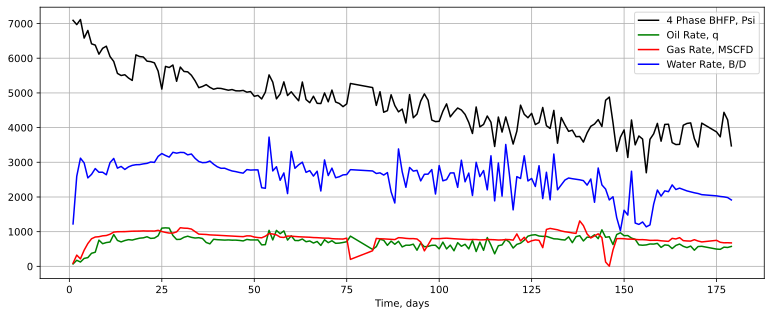

In [25]:
DataValidation()